(공통)문제 1.
이미지 분류 모델을 만들고,
전체 코드와 분류 결과를
주피터 노트북 파일로 자신의 깃헙에 제출합니다.  

- 이미지 데이터를 적절히 전처리 한 후 데이터 파이프라인을 설계합니다.  
- 모델은 VGG-16, VGG-19, ResNet-34, ResNet-50, GoogLeNet 등 케창딥 교재에 소개 된 CNN 모델 중 하나를 선택합니다.  
- 텐서플로우 라이브러리에서 모델을 불러오지 않고, 직접 모델 학습 코드를 짜야 합니다. 
- Data augmentation 등 케창딥에서 배운 모든 방법을 사용해 최고 기록을 달성해보세요.

In [40]:
import os, shutil, pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [41]:
data_path = './archive/chest_xray/chest_xray/'

In [42]:
train = data_path + 'train/'
val = data_path + 'val/'
test = data_path + 'test/'
train_n = data_path + 'train/NORMAL/'
train_p = data_path + 'train/PNEUMONIA/'
val_n = data_path + 'val/NORMAL/'
val_p = data_path + 'val/PNEUMONIA/'
test_n = data_path + 'test/NORMAL/'
test_p = data_path + 'test/PNEUMONIA/'

In [43]:
print("train_n :",len(os.listdir(train_n)))
print("train_p :",len(os.listdir(train_p)))
print("val_n :",len(os.listdir(val_n)))
print("val_p :",len(os.listdir(val_p)))
print("test_n :",len(os.listdir(test_n)))
print("test_p :",len(os.listdir(test_p)))

train_n : 1342
train_p : 3876
val_n : 9
val_p : 9
test_n : 234
test_p : 390


In [44]:
from tensorflow.keras.utils import image_dataset_from_directory

In [45]:
image_size = (56, 56)
batch_size = 32
train_data = image_dataset_from_directory(
    train, image_size=image_size, batch_size=batch_size)
val_data = image_dataset_from_directory(
    val, image_size=image_size, batch_size=batch_size)
test_data = image_dataset_from_directory(
    test, image_size=image_size, batch_size=batch_size)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [46]:
for data_batch, labels_batch in train_data:
    print("데이터배치크기 :",data_batch.shape)
    print("레이블배치크기 :",labels_batch.shape)
    break

데이터배치크기 : (32, 56, 56, 3)
레이블배치크기 : (32,)


In [47]:
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers,models

# 데이터 증식
data_aug = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

In [51]:
#resnet + 데이터 증식 + 모델 파라미터 축소

def residual_block(x, filters, stride=1):
    residual = x

    if stride != 1 or x.shape[-1] != filters:
        residual = layers.Conv2D(filters, 1, strides=stride)(residual)
        residual = layers.BatchNormalization()(residual)

    x = layers.Conv2D(filters, 3, padding='same', strides=stride)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([x, residual])
    x = layers.Activation('relu')(x)

    return x

def resnet(input_shape, num_classes=1):
    inputs = keras.Input(shape=input_shape)
    x = data_aug(inputs)
    x = layers.Conv2D(32, 7, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    x = residual_block(x, 32)
    x = residual_block(x, 64, stride=2)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    return keras.Model(inputs, outputs)

model = resnet((56, 56, 3))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', 
              metrics=['accuracy'])
# 모델 생성


model.summary()



Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 56, 56, 3)]  0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 56, 56, 3)    0           input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_82 (Conv2D)              (None, 28, 28, 32)   4736        sequential_3[1][0]               
__________________________________________________________________________________________________
batch_normalization_75 (BatchNo (None, 28, 28, 32)   128         conv2d_82[0][0]                  
____________________________________________________________________________________________

In [52]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="resnet.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_data,
    epochs=10,
    validation_data=val_data,
    callbacks=callbacks)

Epoch 1/10
163/163 [==============================] - 60s 346ms/step - loss: 0.2751 - accuracy: 0.8815 - val_loss: 7.5468 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 58s 344ms/step - loss: 0.1997 - accuracy: 0.9193 - val_loss: 0.7125 - val_accuracy: 0.6250
Epoch 3/10
163/163 [==============================] - 58s 343ms/step - loss: 0.1756 - accuracy: 0.9285 - val_loss: 1.3264 - val_accuracy: 0.4375
Epoch 4/10
163/163 [==============================] - 58s 343ms/step - loss: 0.1643 - accuracy: 0.9358 - val_loss: 3.0466 - val_accuracy: 0.5000
Epoch 5/10
163/163 [==============================] - 58s 342ms/step - loss: 0.1485 - accuracy: 0.9440 - val_loss: 0.9038 - val_accuracy: 0.6875
Epoch 6/10
163/163 [==============================] - 58s 341ms/step - loss: 0.1426 - accuracy: 0.9442 - val_loss: 1.8765 - val_accuracy: 0.5000
Epoch 7/10
163/163 [==============================] - 58s 343ms/step - loss: 0.1261 - accuracy: 0.9530 - val_loss: 3.8862 - val_ac

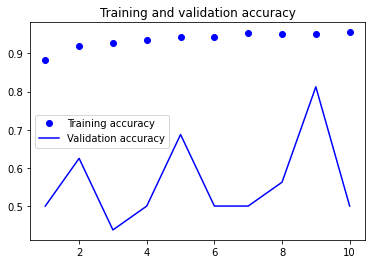

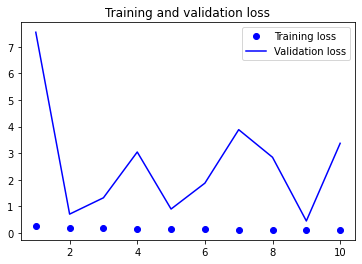

In [53]:
# 훈련 정확도 / 손실 그래프 그리기

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [54]:
# 테스트로 모델 평가

test_model = keras.models.load_model("resnet.keras")
test_loss, test_acc = test_model.evaluate(test_data)
print(f"테스트 정확도: {test_acc:.3f}")

20/20 [==============================] - 6s 139ms/step - loss: 0.3809 - accuracy: 0.8606
테스트 정확도: 0.861


(선택)문제 2. 
이미지 분류 학습 결과를 텐서보드로 시각화합니다. (2점)  

- tensorboard.dev를 사용해 텐서보드 결과를 공유할 수 있는 url 주소 링크를 자신의 깃헙 Main_Quest_2 폴더 내의 Readme.md 파일에 게시합니다.

In [56]:
tensorboard = keras.callbacks.TensorBoard(log_dir="/fullpath")
history = model.fit(
    train_data,
    epochs=5,
    validation_data=val_data,
    callbacks=[tensorboard])

Epoch 1/5
163/163 [==============================] - 59s 351ms/step - loss: 0.1238 - accuracy: 0.9540 - val_loss: 0.8535 - val_accuracy: 0.6250
Epoch 2/5
163/163 [==============================] - 58s 344ms/step - loss: 0.1218 - accuracy: 0.9555 - val_loss: 0.7169 - val_accuracy: 0.5625
Epoch 3/5
163/163 [==============================] - 58s 343ms/step - loss: 0.1100 - accuracy: 0.9582 - val_loss: 2.2688 - val_accuracy: 0.5000
Epoch 4/5
163/163 [==============================] - 58s 345ms/step - loss: 0.1105 - accuracy: 0.9599 - val_loss: 3.0433 - val_accuracy: 0.5000
Epoch 5/5
163/163 [==============================] - 58s 345ms/step - loss: 0.1124 - accuracy: 0.9563 - val_loss: 0.7843 - val_accuracy: 0.6250


In [99]:
!kill 902

In [109]:
%load_ext tensorboard
!tensorboard --logdir=/fullpath --port=16001

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.8.0 at http://localhost:16001/ (Press CTRL+C to quit)
^C


(선택)문제 3. 
가장 성능이 좋은 모델에 CAM을 적용해, 
분류결과에 대한 근거를 시각화하고 분석해보세요. (2점)  

- tensorboard.dev를 사용해 텐서보드 결과를 공유할 수 있는 url 주소 링크를 자신의 깃헙 Main_Quest_2 폴더 내의 Readme.md 파일에 게시합니다.